In this notebook we generate a database of the pulse in which ICRH has been used. 

In theory, the IRFM GED could be used for that... In theory.

In [1]:
import pywed as pw
import numpy as np
from IRFMtb import tsdernier_choc

In [2]:
import matplotlib.pyplot as plt 
from scipy.signal import savgol_filter

In [3]:
pulse_start = 53550  # first plasma with IC for W3b (tbc)
pulse_end = tsdernier_choc()
pulses = np.arange(pulse_start, pulse_end)

In [4]:
pulses[-1]

53844

In [5]:
pulse_list, Ptot_max = [], []

# try to read the total injected power for every pulse. 
# Keep only the pulse numbers where the data exist 
for pulse in pulses:
    try:
        Ptot, t = pw.tsbase(int(pulse), 'SICHPTOT', nargout=2)
        
        pulse_list.append(pulse)
        Ptot_max.append(np.amax(Ptot))
        
    except pw.PyWEDException as e:
        pass

np.save('WESTC3b_pulse_list.csv', pulse_list)

You're asking a lot of data, please wait


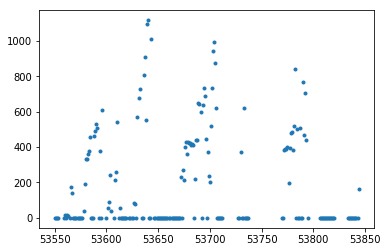

In [6]:
fig, ax = plt.subplots()
ax.plot(pulse_list, Ptot_max, '.')

In [7]:
def smooth(y):
    return savgol_filter(y, 51, 3)

In [29]:
def filter_data(y, t, thres_min=0, thres_max=1e9, dt=0.2):
    " find and replace non-physical values by NaN "
    t2 = np.where(y > thres_min, t, np.NaN)
    y2 = np.where(y > thres_min, y, np.NaN)
    
    t2 = np.where(y < thres_max, t2, np.NaN)
    y2 = np.where(y < thres_max, y2, np.NaN)

    " find and replace data to tmin+dt and tmax-dt"
    #idx = np.where(~np.isnan(t2))
    #if np.any(idx):
    #    print(idx)
    #    t2 = t2[np.where((t2 > t2[idx][0] + dt) & (t2 < t2[idx][-1] - dt))]
    #    y2 = y2[np.where((t2 > t2[idx][0] + dt) & (t2 < t2[idx][-1] - dt))]
    
    return y2, t2

In [9]:
def get_sig(pulse, signame):
    y, t = pw.tsbase(pulse, signame, nargout=2)
    return y, t

In [10]:
def get_Ptot_min_avg_max(pulse):
    Ptot, t = get_Ptot(pulse)
    Ptot, t = filter_sig(Ptot, t, thres_min=50)
    if t.any():
        Ptot, t = filter_time(Ptot, t)
    return get_min_avg_max(Ptot)

def get_min_avg_max(y):
    if y.any():
        return [np.nanmin(y), np.nanmean(y), np.nanmax(y)]
    else:
        return [np.nan, np.nan, np.nan]

In [11]:
# populates the database
data = {}

for pulse in pulse_list:
    pulse = int(pulse)

    # Q1
    Rc, t = get_sig(pulse, 'GICHCOUPRES%1')    
    left = {'Rc': Rc, 't': t}
    
    Rc, t = get_sig(pulse, 'GICHCOUPRES%2')   
    right = {'Rc': Rc, 't': t}
    
    Q1 = {'left': left, 
          'right': right}
    # Q2
    Rc, t = get_sig(pulse, 'GICHCOUPRES%3')    
    left = {'Rc': Rc, 't': t}
    
    Rc, t = get_sig(pulse, 'GICHCOUPRES%4')   
    right = {'Rc': Rc, 't': t}
    
    Q2 = {'left': left, 
          'right': right}
    
    Ptot, t = get_sig(pulse, 'SICHPTOT')
    
    data[pulse] = {'Q1': Q1, 
                   'Q2': Q2, 
                   'Ptot_max': np.nanmax(Ptot), 
                   'Ptot': Ptot, 't': t}
# TODO try better storage format
np.savez('data.npz', data)

You're asking a lot of data, please wait


In [43]:
def get_Rc(data, pulse, antenna='Q1', side='left'):
    Rc, t = data[pulse][antenna][side]['Rc'], data[pulse][antenna][side]['t']
    if np.all(Rc < 0.1):
        return np.nan, np.nan
    else:
        Rc, t = filter_data(Rc, t, thres_min=0.05, thres_max=3)
        #Rc = smooth(Rc)
        return Rc, t

def get_max_Rc(data, pulse, antenna='Q1', side='left'):
    Rc, t =  get_Rc(data, pulse, antenna, side)
    if np.any(Rc):
        return np.nanmax(Rc)
    else: 
        return np.nan

In [44]:
get_max_Rc(data, 53706, antenna='Q2', side='right')

0.1170000055572018

In [45]:
Rc_data = []

for pulse in data:
    Rc_Q1_left = get_max_Rc(data, pulse, antenna='Q1', side='left')
    Rc_Q1_right = get_max_Rc(data, pulse, antenna='Q1', side='right')
    Rc_Q2_left = get_max_Rc(data, pulse, antenna='Q2', side='left')
    Rc_Q2_right = get_max_Rc(data, pulse, antenna='Q2', side='right')
    Rc_data.append([Rc_Q1_left, Rc_Q1_right, Rc_Q2_left, Rc_Q2_right])

C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
  del sys.path[0]
C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: All-NaN axis encountered
  del sys.path[0]


In [46]:
pulses = np.array(list(data.keys()))
Rcs = np.array(Rc_data)

In [62]:
Rc_Q1 = np.mean(Rcs[:,0:2], axis=1)
Rc_Q2 = np.mean(Rcs[:,2:], axis=1)

(0, 1.5)

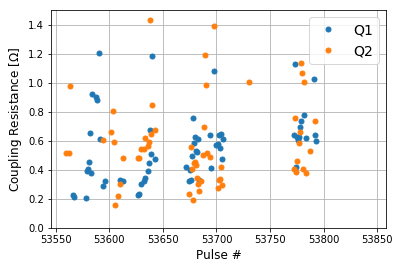

In [73]:
fig, ax = plt.subplots()
ax.plot(pulses, Rc_Q1, '.', ms=10, label='Q1') 
ax.plot(pulses, Rc_Q2, '.', ms=10, label='Q2')
ax.set_xlabel('Pulse #', fontsize=12)
ax.set_ylabel('Coupling Resistance [$\Omega$]', fontsize=12)
ax.grid(True)
ax.legend(fontsize=14, loc='upper right')
ax.set_ylim(0, 1.5)

In [39]:
Rcs

array([[       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [0.18700001, 0.18700001, 0.18700001, 0.18700001],
       [0.16100001, 0.16100001, 0.16100001, 0.16100001],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,